In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Util Functions

In [2]:
def define_paths(dir):
    filepaths = []
    labels = []
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels


def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


def create_df(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

### Loading data with tensorflow

In [3]:
def create_gens(train_df, valid_df, test_df, batch_size):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    ts_length = len(test_df)
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= 40)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= 40)
    return train_gen, valid_gen, test_gen


dir = '/kaggle/input/satellite-image-classification/data'

df = create_df(dir)
train_df, test_valid_df = train_test_split(df, test_size=0.2, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)

# Get Generators
batch_size = 200
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 4504 validated image filenames belonging to 4 classes.
Found 564 validated image filenames belonging to 4 classes.
Found 563 validated image filenames belonging to 4 classes.


### EfficientNet

We will you the base model weight (no retraining) and add a Batch Normalization layer as well as a couple of dense layers seperated with droput so we dont overfit 

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

43941136/43941136 [==============================] - 0s 0us/step
Epoch 1/10


2024-04-28 16:56:20.206542: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


113/113 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8892
Epoch 1: val_accuracy improved from -inf to 0.94326, saving model to best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 57s 374ms/step - loss: 0.3278 - accuracy: 0.8892 - val_loss: 0.1527 - val_accuracy: 0.9433
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9465
Epoch 2: val_accuracy improved from 0.94326 to 0.97872, saving model to best_model.h5
113/113 [==============================] - 19s 165ms/step - loss: 0.1678 - accuracy: 0.9465 - val_loss: 0.0915 - val_accuracy: 0.9787
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9669
Epoch 3: val_accuracy did not improve from 0.97872
113/113 [==============================] - 18s 160ms/step - loss: 0.0988 - accuracy: 0.9669 - val_loss: 0.0780 - val_accuracy: 0.9787
Epoch 4/10
113/113 [==============================] - ETA: 0s - loss: 0.1098 - accuracy: 0.9665
Epoch 4: val_accuracy did not improve from 0.97872
113/113 [==============================] - 18s 161ms/step - loss: 0.1098 - accuracy: 0.9665 - val_loss: 0.0894 - val_accur

### Lets load the best model and test it

In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average

model= load_model('best_model.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

563/563 [==============================] - 5s 8ms/step - loss: 0.0682 - accuracy: 0.9769
Train Loss:  0.013592994771897793
Train Accuracy:  0.9964476227760315
--------------------
Validation Loss:  0.04615674912929535
Validation Accuracy:  0.98758864402771
--------------------
Test Loss:  0.06823602318763733
Test Accuracy:  0.9769093990325928


#### A 97.51 accuracy on the training set

Lets look closly at the confusion matrix

563/563 [==============================] - 5s 3ms/step


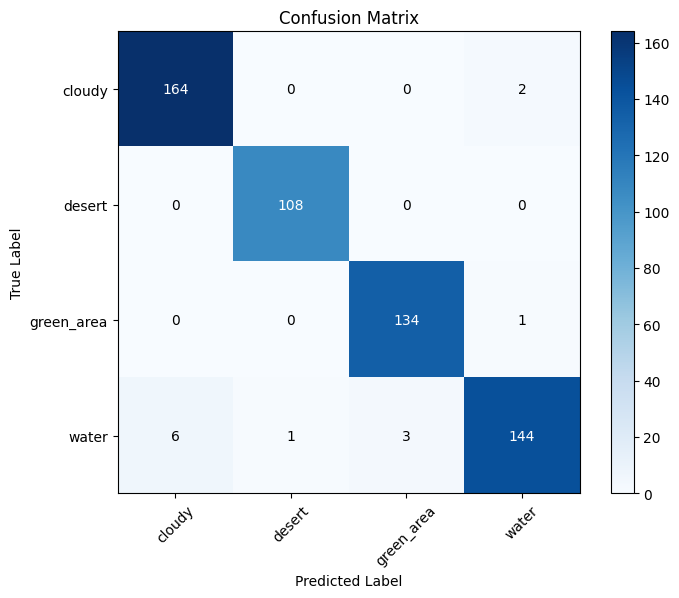

In [10]:
import matplotlib.pyplot as plt

test_pred = model.predict(test_gen, steps= test_steps, verbose= 1)

test_labels = test_gen.classes
test_preds = np.argmax(test_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(test_gen.class_indices))
class_labels = list(test_gen.class_indices.keys())
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Add values to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
        
plt.show()


### further look at the predictions

In [11]:
import numpy as np

# Assuming you have the true labels and predicted labels
true_labels = test_gen.classes  # Convert one-hot to integer labels
predicted_labels = np.argmax(test_pred, axis=1)

correctly_classified = np.where(true_labels == predicted_labels)[0]
misclassified = np.where(true_labels != predicted_labels)[0]

In [15]:
misclassified_df = test_df.iloc[misclassified]

mapped_labels = [list(test_gen.class_indices.keys())[list(test_gen.class_indices.values()).index(label)] for label in np.array(predicted_labels)[list(misclassified)]]

misclassified_df['predicted'] = mapped_labels

/tmp/ipykernel_26/4256197914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['predicted'] = mapped_labels


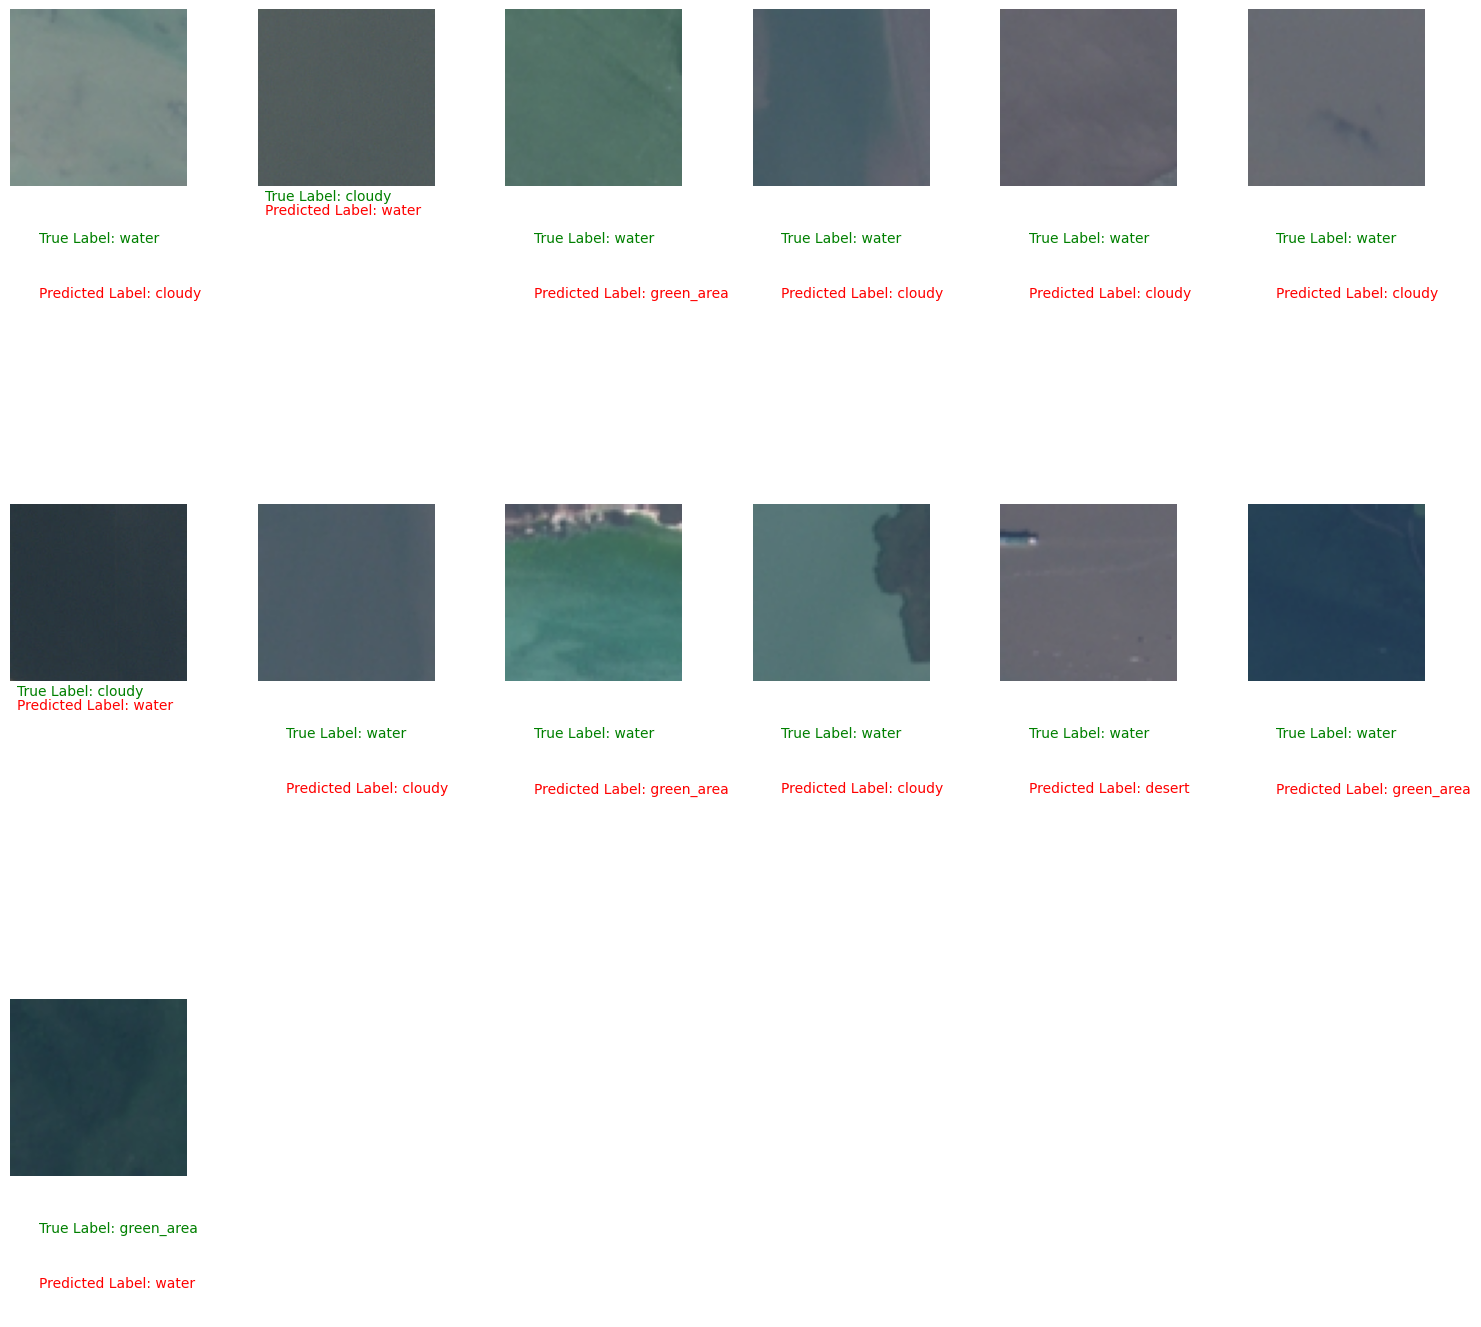

In [20]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Calculate number of rows and columns based on the number of images
num_images = len(misclassified_df)
num_columns = 6
num_rows = -(-num_images // num_columns)  # Ceiling division

# Function to display image with labels
def display_image_with_labels(ax, row):
    image_path = row['filepaths']
    true_label = row['labels']
    predicted_label = row['predicted']
    
    # Read image
    img = Image.open(image_path)
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Display true and predicted labels
    ax.text(10, img.height + 20, f'True Label: {true_label}', fontsize=10, color="green")
    ax.text(10, img.height + 40, f'Predicted Label: {predicted_label}', fontsize=10, color="red")

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

# Flatten axes if necessary
if num_rows == 1:
    axes = [axes]

# Display images with labels
for i, row in misclassified_df.reset_index().iterrows():
    ax = axes[i // num_columns, i % num_columns]
    display_image_with_labels(ax, row)

# Hide empty subplots
for i in range(num_images, num_rows * num_columns):
    ax = axes[i // num_columns, i % num_columns]
    ax.axis('off')

plt.tight_layout()
plt.show()

### ResNet50

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/10
113/113 [==============================] - ETA: 0s - loss: 0.1955 - accuracy: 0.9396
Epoch 1: val_accuracy improved from -inf to 0.99291, saving model to best_model_resnet.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - 27s 185ms/step - loss: 0.1955 - accuracy: 0.9396 - val_loss: 0.0245 - val_accuracy: 0.9929
Epoch 2/10
113/113 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.9818
Epoch 2: val_accuracy improved from 0.99291 to 0.99645, saving model to best_model_resnet.h5
113/113 [==============================] - 18s 156ms/step - loss: 0.0632 - accuracy: 0.9818 - val_loss: 0.0125 - val_accuracy: 0.9965
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9840
Epoch 3: val_accuracy improved from 0.99645 to 1.00000, saving model to best_model_resnet.h5
113/113 [==============================] - 18s 155ms/step - loss: 0.0693 - accuracy: 0.9840 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/10
113/113 [==============================] - ETA: 0s - loss: 0.0477 - accuracy: 0.9898
Epoch 4: val_accuracy did not improve from 1.00000
113/113 [==============================] - 17s 149ms/step - loss: 0.0477 

In [22]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

563/563 [==============================] - 3s 4ms/step - loss: 0.0210 - accuracy: 0.9964
Train Loss:  0.006447822321206331
Train Accuracy:  0.998001754283905
--------------------
Validation Loss:  0.0034388573840260506
Validation Accuracy:  1.0
--------------------
Test Loss:  0.02098826877772808
Test Accuracy:  0.9964476227760315


#### Confusion Matrix

563/563 [==============================] - 3s 3ms/step


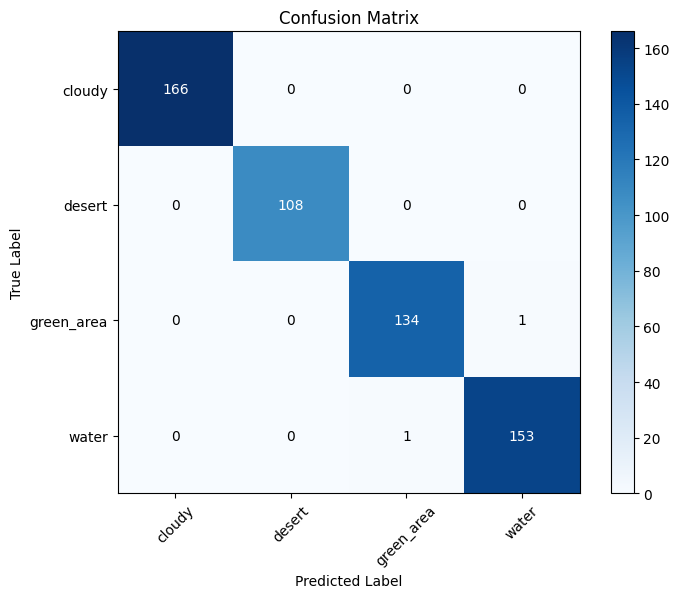

In [23]:
import matplotlib.pyplot as plt

test_pred = model.predict(test_gen, steps= test_steps, verbose= 1)

test_labels = test_gen.classes
test_preds = np.argmax(test_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(test_gen.class_indices))
class_labels = list(test_gen.class_indices.keys())
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Add values to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
        
plt.show()


#### Error analysis

In [24]:
import numpy as np

# Assuming you have the true labels and predicted labels
true_labels = test_gen.classes  # Convert one-hot to integer labels
predicted_labels = np.argmax(test_pred, axis=1)

correctly_classified = np.where(true_labels == predicted_labels)[0]
misclassified = np.where(true_labels != predicted_labels)[0]

In [25]:
misclassified_df = test_df.iloc[misclassified]

mapped_labels = [list(test_gen.class_indices.keys())[list(test_gen.class_indices.values()).index(label)] for label in np.array(predicted_labels)[list(misclassified)]]

misclassified_df['predicted'] = mapped_labels

/tmp/ipykernel_26/4256197914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['predicted'] = mapped_labels


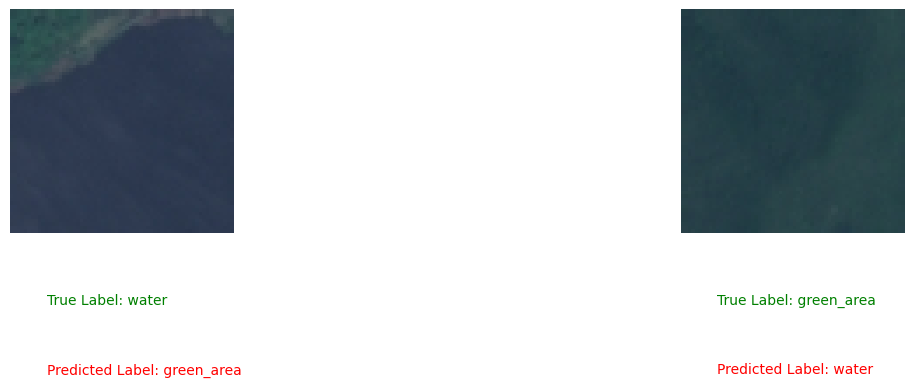

In [31]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Calculate number of rows and columns based on the number of images
num_images = len(misclassified_df)
num_columns = 2
num_rows = -(-num_images // num_columns)  # Ceiling division

# Function to display image with labels
def display_image_with_labels(ax, row):
    image_path = row['filepaths']
    true_label = row['labels']
    predicted_label = row['predicted']
    
    # Read image
    img = Image.open(image_path)
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Display true and predicted labels
    ax.text(10, img.height + 20, f'True Label: {true_label}', fontsize=10, color="green")
    ax.text(10, img.height + 40, f'Predicted Label: {predicted_label}', fontsize=10, color="red")

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

# Flatten axes if necessary
if num_rows == 1:
    axes = [axes]

# Display images with labels
for i, row in misclassified_df.reset_index().iterrows():
    ax = axes[i // num_columns][i % num_columns]  # Fix the indexing here
    display_image_with_labels(ax, row)

# Hide empty subplots
for i in range(num_images, num_rows * num_columns):
    ax = axes[i // num_columns][i % num_columns]  # Fix the indexing here
    ax.axis('off')

plt.tight_layout()
plt.show()


### VGG16

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_vgg.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=10,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/10
113/113 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8952
Epoch 1: val_accuracy improved from -inf to 0.94504, saving model to best_model_vgg.h5
113/113 [==============================] - 36s 248ms/step - loss: 0.3055 - accuracy: 0.8952 - val_loss: 0.1393 - val_accuracy: 0.9450
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


113/113 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9705
Epoch 2: val_accuracy improved from 0.94504 to 0.97872, saving model to best_model_vgg.h5
113/113 [==============================] - 23s 199ms/step - loss: 0.0916 - accuracy: 0.9705 - val_loss: 0.0727 - val_accuracy: 0.9787
Epoch 3/10
113/113 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9756
Epoch 3: val_accuracy improved from 0.97872 to 0.98759, saving model to best_model_vgg.h5
113/113 [==============================] - 22s 195ms/step - loss: 0.0666 - accuracy: 0.9756 - val_loss: 0.0722 - val_accuracy: 0.9876
Epoch 4/10
113/113 [==============================] - ETA: 0s - loss: 0.0528 - accuracy: 0.9836
Epoch 4: val_accuracy improved from 0.98759 to 0.99113, saving model to best_model_vgg.h5
113/113 [==============================] - 22s 196ms/step - loss: 0.0528 - accuracy: 0.9836 - val_loss: 0.0701 - val_accuracy: 0.9911
Epoch 5/10
113/113 [==============================]

In [34]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_vgg.h5')

ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

563/563 [==============================] - 3s 4ms/step - loss: 0.0555 - accuracy: 0.9893
Train Loss:  0.011259899474680424
Train Accuracy:  0.9955595135688782
--------------------
Validation Loss:  0.04030804708600044
Validation Accuracy:  0.9929078221321106
--------------------
Test Loss:  0.05551956966519356
Test Accuracy:  0.9893428087234497


#### Confusion Matrix

563/563 [==============================] - 3s 4ms/step


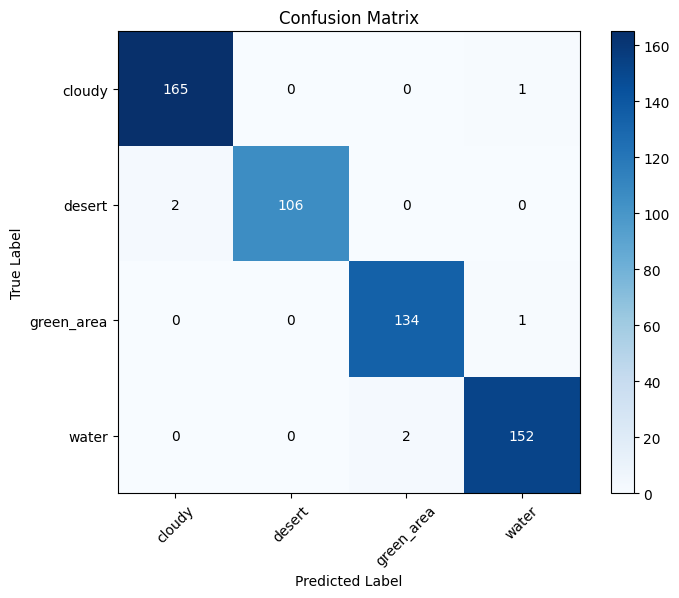

In [35]:
import matplotlib.pyplot as plt

test_pred = model.predict(test_gen, steps= test_steps, verbose= 1)

test_labels = test_gen.classes
test_preds = np.argmax(test_pred, axis=1)

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(test_gen.class_indices))
class_labels = list(test_gen.class_indices.keys())
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Add values to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
        
plt.show()


#### Error Analysis

In [37]:
import numpy as np

# Assuming you have the true labels and predicted labels
true_labels = test_gen.classes  # Convert one-hot to integer labels
predicted_labels = np.argmax(test_pred, axis=1)

correctly_classified = np.where(true_labels == predicted_labels)[0]
misclassified = np.where(true_labels != predicted_labels)[0]

In [38]:
misclassified_df = test_df.iloc[misclassified]

mapped_labels = [list(test_gen.class_indices.keys())[list(test_gen.class_indices.values()).index(label)] for label in np.array(predicted_labels)[list(misclassified)]]

misclassified_df['predicted'] = mapped_labels

/tmp/ipykernel_26/4256197914.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclassified_df['predicted'] = mapped_labels


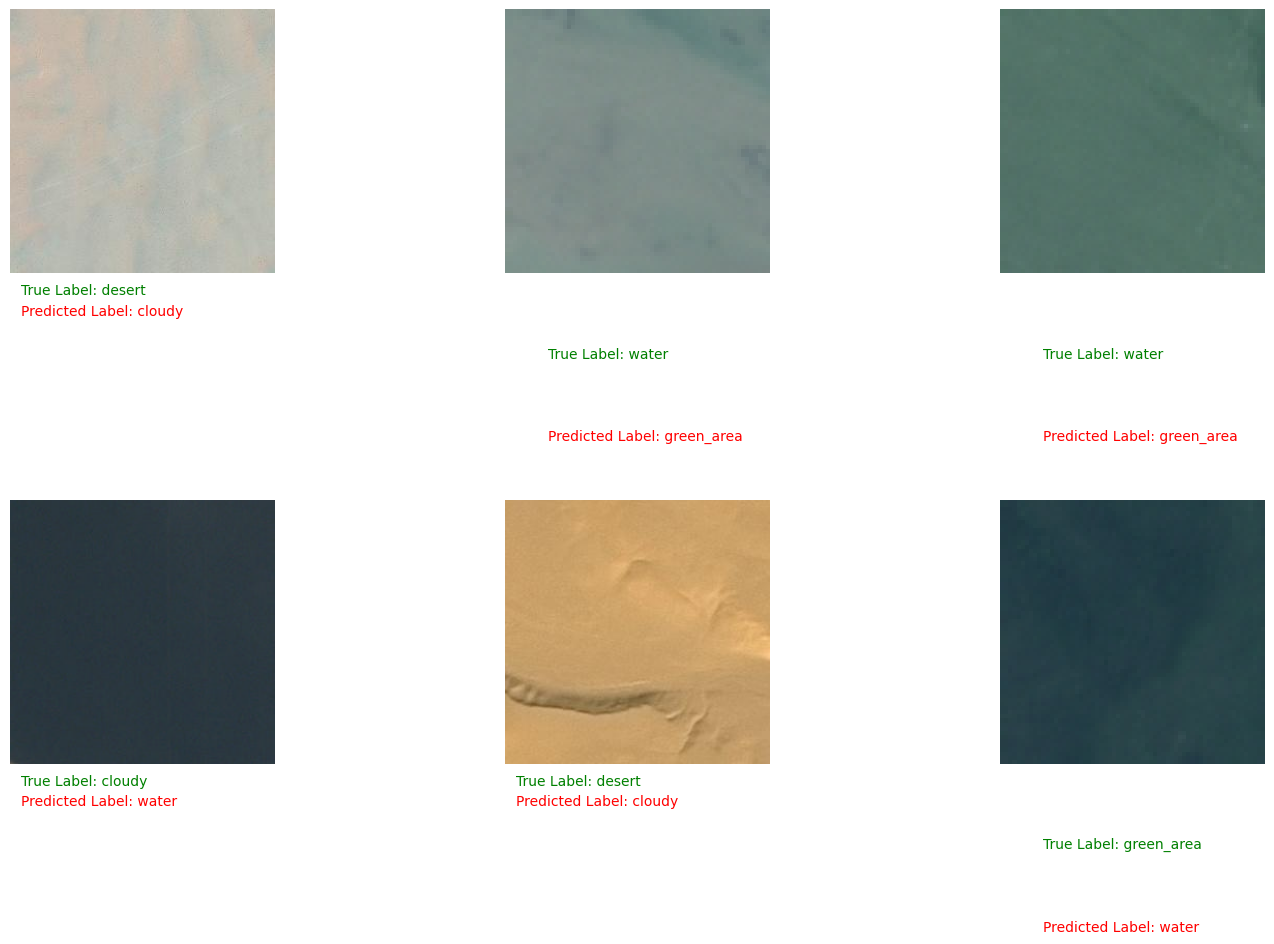

In [40]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Calculate number of rows and columns based on the number of images
num_images = len(misclassified_df)
num_columns = 3
num_rows = -(-num_images // num_columns)  # Ceiling division

# Function to display image with labels
def display_image_with_labels(ax, row):
    image_path = row['filepaths']
    true_label = row['labels']
    predicted_label = row['predicted']
    
    # Read image
    img = Image.open(image_path)
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Display true and predicted labels
    ax.text(10, img.height + 20, f'True Label: {true_label}', fontsize=10, color="green")
    ax.text(10, img.height + 40, f'Predicted Label: {predicted_label}', fontsize=10, color="red")

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

# Flatten axes if necessary
if num_rows == 1:
    axes = [axes]

# Display images with labels
for i, row in misclassified_df.reset_index().iterrows():
    ax = axes[i // num_columns][i % num_columns]  # Fix the indexing here
    display_image_with_labels(ax, row)

# Hide empty subplots
for i in range(num_images, num_rows * num_columns):
    ax = axes[i // num_columns][i % num_columns]  # Fix the indexing here
    ax.axis('off')

plt.tight_layout()
plt.show()
